In [2]:
import pandas as pd
import numpy as np
import requests
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle
import lightgbm as lgb


In [66]:
# Load your dataset
data = pd.read_csv("Merged.csv")

# Drop missing values
data = data.dropna()

# Fix label inconsistencies
label_corrections = {
    "Neutural": "Neutral", "Meutral": "Neutral", "N EUTRAL": "Neutral",
    "NEUTRANEG": "Neutral", "Negetive": "Negative", "NEGNEG": "Negative",
    "Negativee": "Negative", "NEG": "Negative"
}
data['tag'] = data['tag'].replace(label_corrections)

# Remove Neutral labels
data = data[data['tag'] != 'Neutral']

# Balance the dataset
unique_labels = data['tag'].unique()
positive_class_label = unique_labels[0]
positive_class = data[data['tag'] == positive_class_label]

if len(positive_class) >= 8480:
    rows_to_remove = positive_class.sample(n=8480, random_state=42)
    data = data.drop(rows_to_remove.index)

print("✅ Dataset cleaned successfully!")


✅ Dataset cleaned successfully!


In [67]:
stopwords_url = "https://raw.githubusercontent.com/stopwords-iso/stopwords-bn/master/stopwords-bn.txt"
response = requests.get(stopwords_url)

if response.status_code == 200:
    stop_words_bangla = set(response.text.splitlines())
    data['comment'] = data['comment'].apply(lambda x: ' '.join([word for word in str(x).split() if word.lower() not in stop_words_bangla]))

print("✅ Stopwords removed!")


✅ Stopwords removed!


In [68]:
X_train, X_test, y_train, y_test = train_test_split(data['comment'], data['tag'], test_size=0.2, random_state=42)

# TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# Label Encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

print("✅ TF-IDF and label encoding done!")


✅ TF-IDF and label encoding done!


In [69]:
# Convert to LightGBM dataset format
train_data = lgb.Dataset(X_train_tfidf, label=y_train_encoded)
test_data = lgb.Dataset(X_test_tfidf, label=y_test_encoded, reference=train_data)

# Set parameters
params = {
    'objective': 'multiclass',
    'num_class': len(label_encoder.classes_),
    'metric': 'multi_logloss',
    'verbosity': -1,
    'seed': 42
}

# Train model
lgb_model = lgb.train(params, train_data, num_boost_round=100)

print("✅ LightGBM model trained!")


✅ LightGBM model trained!


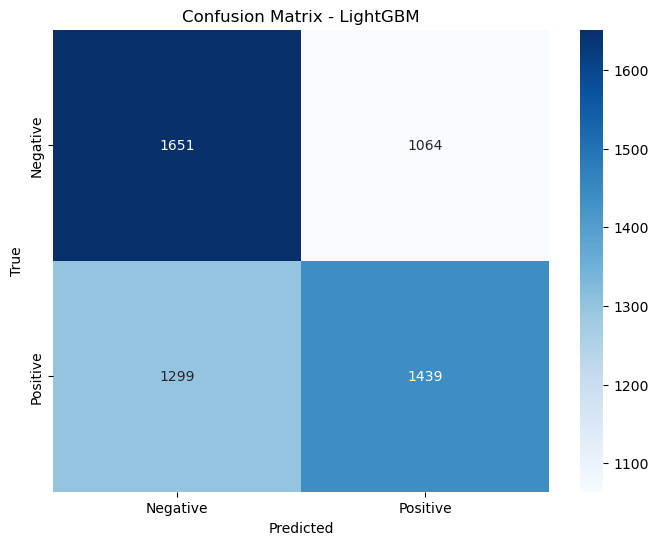

In [70]:
y_pred_probs = lgb_model.predict(X_test_tfidf)
y_pred = np.argmax(y_pred_probs, axis=1)

conf_matrix = confusion_matrix(y_test_encoded, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - LightGBM')
plt.show()


In [71]:
print("Classification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_, zero_division=0))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.56      0.61      0.58      2715
    Positive       0.57      0.53      0.55      2738

    accuracy                           0.57      5453
   macro avg       0.57      0.57      0.57      5453
weighted avg       0.57      0.57      0.57      5453



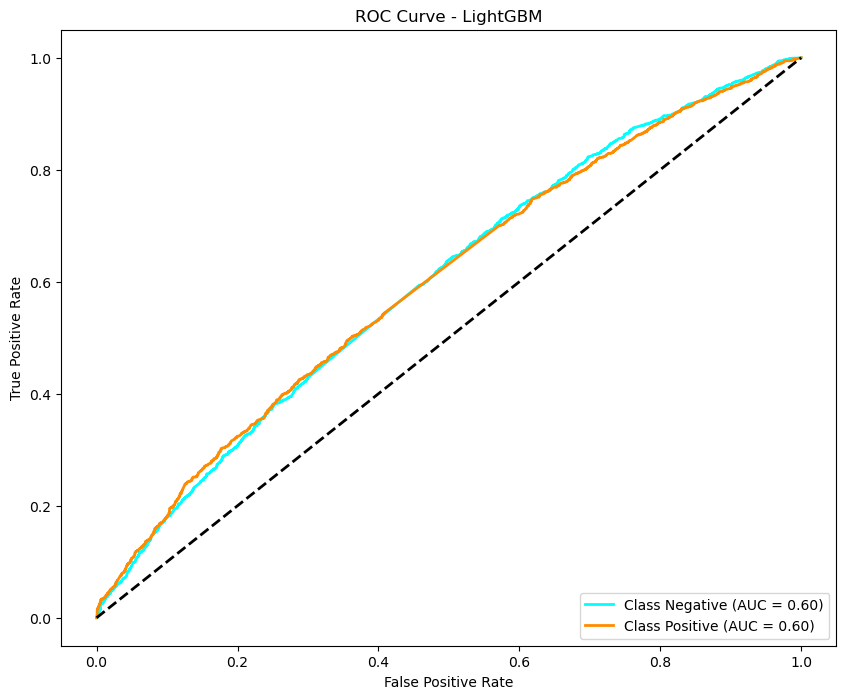

In [72]:
y_test_bin = np.eye(len(label_encoder.classes_))[y_test_encoded]

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10,8))
colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(len(label_encoder.classes_)), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f'Class {label_encoder.classes_[i]} (AUC = {roc_auc[i]:0.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LightGBM')
plt.legend(loc="lower right")
plt.show()


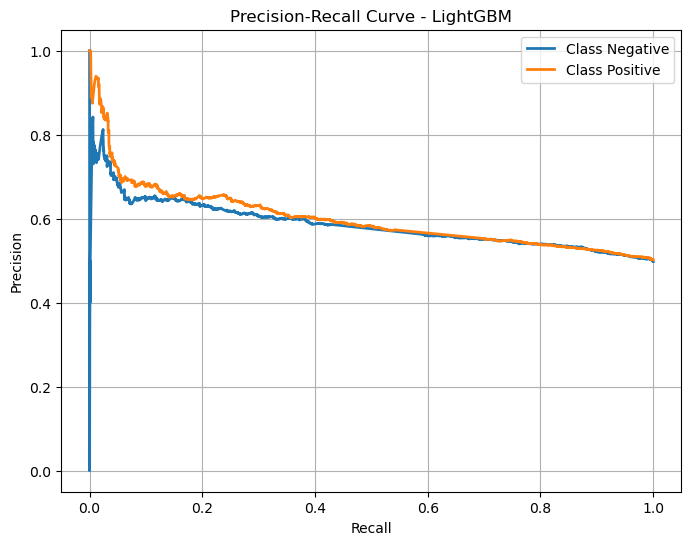

In [73]:
plt.figure(figsize=(8,6))

for i in range(len(label_encoder.classes_)):
    precision, recall, _ = precision_recall_curve(y_test_bin[:, i], y_pred_probs[:, i])
    plt.plot(recall, precision, lw=2, label=f'Class {label_encoder.classes_[i]}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - LightGBM")
plt.legend(loc="best")
plt.grid()
plt.show()
